### The objective of what we are doing here is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

### Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.



### For another data science mini projects and related projects, kindly visit my github:

https://github.com/danielbeltsazar99/My-Mini-Projects

# Twitter Sentiment/Speech Analysis and Modelling

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Twitter Tweets Sentiment Dataset

In [3]:
df_train = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/train.csv")
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df_val = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/test.csv")
df_val.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
print("Training data shape:",df_train.shape)
print("Validation data shape:",df_val.shape)

Training data shape: (31962, 3)
Validation data shape: (17197, 2)


In [6]:
df_train.tweet = df_train.tweet.astype('str')
df_val.tweet = df_val.tweet.astype('str')

# 3. Data Cleaning For Sentiment Processing

In [7]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Null values Cleaning

In [8]:
df_train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

### But after we've seen that the missing values are only in app name feature, we will ignore them anyway.

### Duplicate Values Removing

In [9]:
df_train = df_train.drop_duplicates(keep='first')

In [10]:
df_train.shape

(31962, 3)

### We make a function to clean some basic characters

In [11]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### We make a function to remove "user" word that often appears in our tweet sentences

In [12]:
def remove_username(text):
    cleaned_string = re.sub(r"user", ' ', text)
    return cleaned_string

### We make function to remove numeric

In [13]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make function to remove emoji

In [14]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make function to unify whitespaces

In [15]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make function to remove symbols

In [16]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### We make function to remove punctuation

In [17]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### We make function to remove stopwords

In [18]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### We make function to use stemming to normalize words

In [19]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all the cleaning functions

In [20]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(remove_username)
    df[review] = df[review].apply(Stemming)

In [21]:
cleaning(df_train,'tweet')

In [22]:
df_train[['tweet']].head(20)

,tweet
0,father dysfunct selfish drag kid dysfunct run
1,thank lyft credit use caus offer wheelchair va...
2,bihday majesti
3,model love u take u time ur
4,factsguid societi motiv
5,huge fan fare big talk leav chao pay disput ge...
6,camp tomorrow danni
7,next school year year exam think school exam h...
8,love land allin cav champion cleveland clevela...
9,welcom gr


# 4. Analysis and Visualization

## 3.1. Distribution of Tweets in Each Sentiment

In [23]:
temp = df_train.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')


,label,tweet
0,0,29720
1,1,2242


### We will see the visualization of it.

<AxesSubplot:xlabel='label', ylabel='count'>

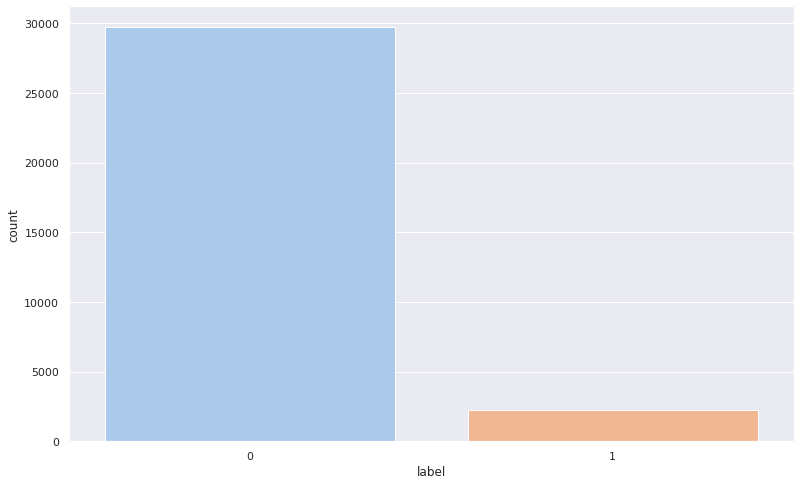

In [24]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='label',data=df_train)

### We can see that there are more positive sentiment tweets than negative sentiment tweets.

## 3.2. WordCloud of Our Tweets Text

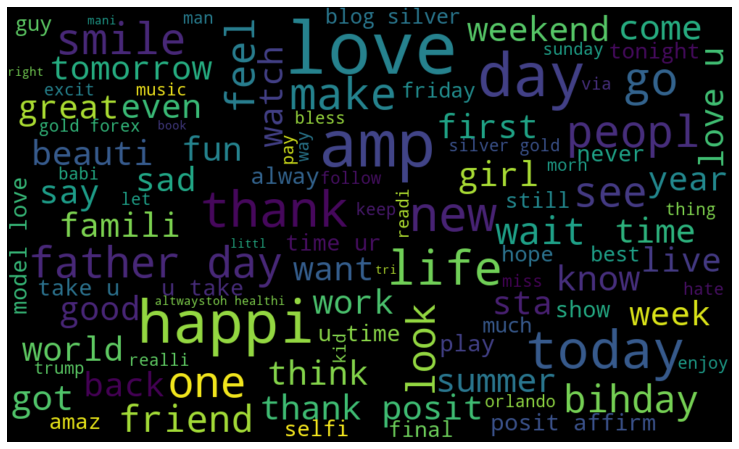

In [25]:
txt = ' '.join(rev for rev in df_train.tweet)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.3. WordCloud of Each Sentiment Tweets

In [26]:
negative = df_train[df_train['label']==1]
positive = df_train[df_train['label']==0]

## Positive Sentiment Tweets

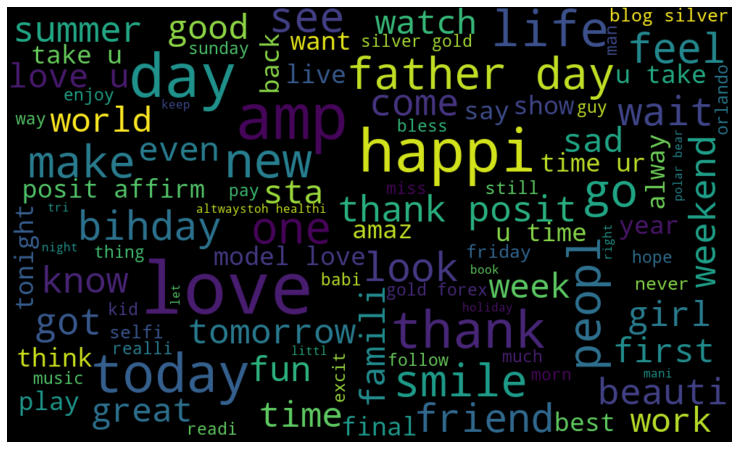

In [27]:
txt = ' '.join(rev for rev in positive.tweet)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We can see that for postive sentiment tweets, the most common words are 'thank',  'beauti (comes from beautiful)',  'love',  'happi (comes from happy or happiness)', etc as shown in picture above.

## Negative Sentiment Tweets

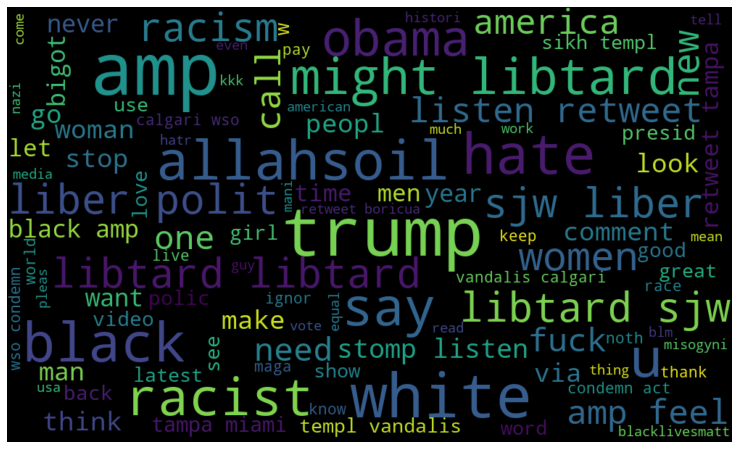

In [28]:
txt = ' '.join(rev for rev in negative.tweet)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### And we can see that for negative sentiment tweets, the most common words are 'hate', 'racist', 'trump', 'libtard', etc as shown in picture above.

## 3.4. Distribution of Number of Tweet Words

### First we create additional features to count number of words in each tweet

In [29]:
df_vis = df_train.copy()

In [30]:
df_vis['Num_word_tweet'] = df_vis['tweet'].apply(lambda x:len(str(x).split()))

### Than we can plot them

<AxesSubplot:xlabel='Num_word_tweet', ylabel='Count'>

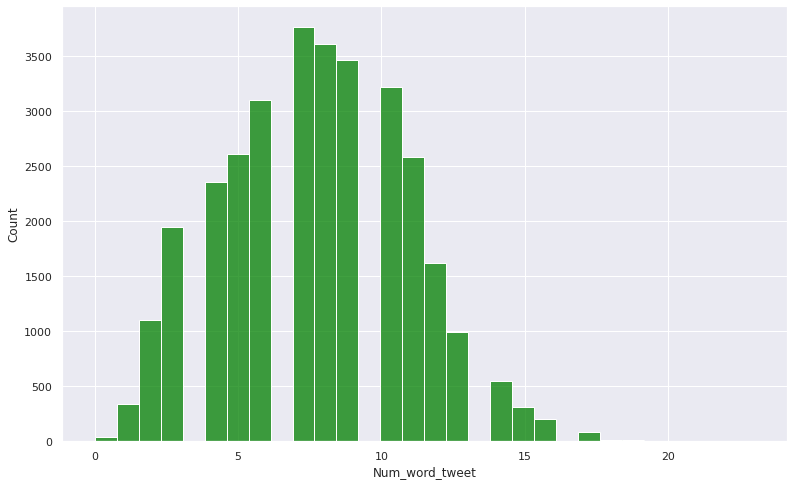

In [31]:
sns.histplot(data=df_vis, x="Num_word_tweet",bins=30,color='green')

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py

Text(0.5, 0.98, 'Average word length in each tweet')

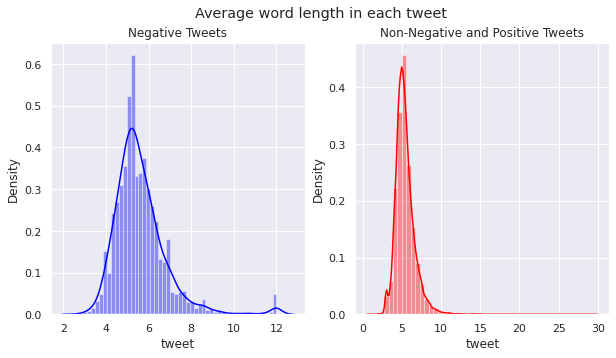

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df_train[df_train['label']==1]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Negative Tweets')
word=df_train[df_train['label']==0]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Non-Negative and Positive Tweets')
fig.suptitle('Average word length in each tweet')

### As we can see that most of our tweets contain 1-15 words. For negative tweets most of the tweets contain 2-12 words with average of 5 words. On the other hand, for non-negative tweets mos of the tweets contain 1-15 words with average of 5 words as shown in graphs above.

## 3.5. Distribution of Words in All Tweets

In [33]:
df_vis['temp_list'] = df_vis['tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,love,3229
1,day,2890
2,happi,2104
3,amp,1778
4,thank,1573
5,get,1257
6,time,1251
7,life,1165
8,u,1163
9,go,1156


### We can plot them

<AxesSubplot:xlabel='count', ylabel='Common_words'>

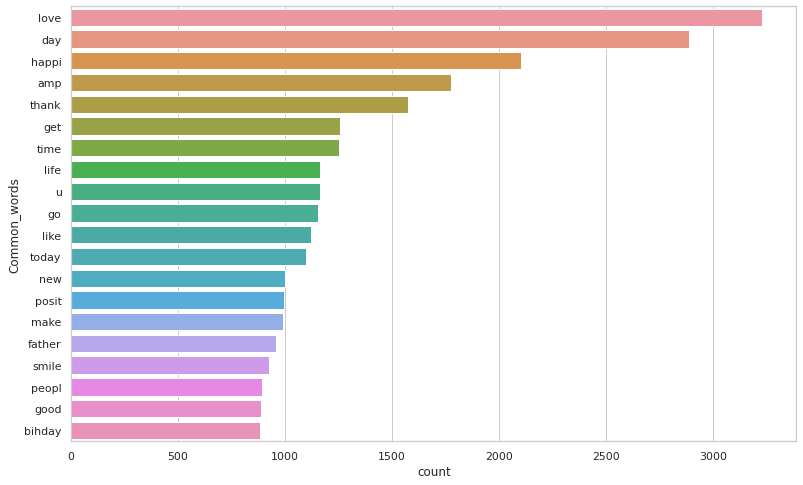

In [34]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

### Then We can see that the word "love" , "day" , "happi" are the top 3 common words in our tweets.

# 5. Creating Bag of Words and Text Classifier Model

## 5.1. Creating pipeline for tokenizing and modelling

### Here i use count vectorizer for tokenizing and random forest as classifier model.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=3000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [36]:
X = df_train['tweet']
y = df_train['label']

## 5.2. Tokenizing and Model Training

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20,stratify=y)


In [38]:
text_classifier = clf.fit(X_train,y_train)

In [39]:
predictions = text_classifier.predict(X_test)

In [40]:
np.unique(predictions)

array([0, 1])

## 5.3. Model's Performance

In [41]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score
confusion_matrix(y_test,predictions)

array([[5889,   56],
       [ 189,  259]])

In [42]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred)))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [43]:
Confusion_Matrix(y_test,predictions)

TN - True Negative 5889
FP - False Positive 56
FN - False Negative 189
TP - True Positive 259
Accuracy Rate: 0.9616768340372283
F1-Score: 0.6788990825688074
Misclassification Rate: 0.03832316596277178
ROC-AUC 0.7843526597981497


<AxesSubplot:>

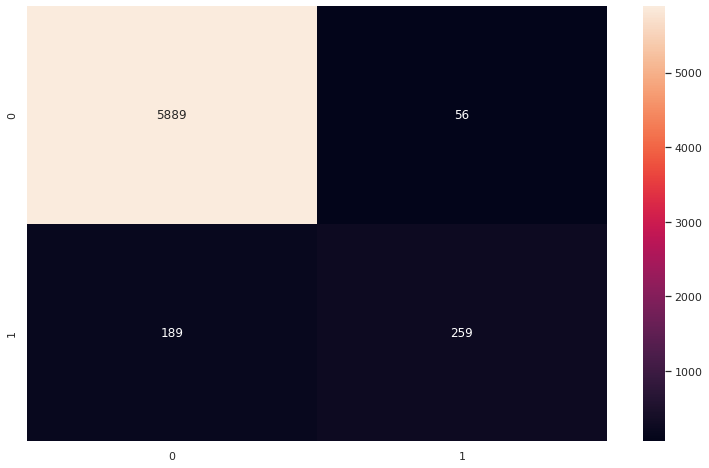

In [44]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

### We see from above confusion matrix that our model has validation accuracy of 96.26 %. It is good, but remember that our tweets data is highly imbalanced between positive and negative sentiment class. So we must check other metrics.

### We use F1-Score as our alternative metrics. We got F1-Score of 0.689. It is very bad. Our model will not be able to perfectly distinguish the positive sentiment class values from the negative sentiment class values.

### Our other solution is to use Oversampling or Undersampling algorithm to balancing our tweets data.

## 5.4. Creating New Model Using Smote and Undersampling Algorithm

### First we import some libraries for oversampling and undersampling

In [45]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL
from numpy import where,mean
from collections import Counter
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score

### Then we create all variables needed for pipeline, such as vectorizer, tf-idf transformer, oversampling using SMOTE, undersampling using RandomUnderSampler, and our machine learning model (in this case we are using random forest classifier)

In [46]:
vect = CountVectorizer(stop_words= "english",max_features=3000)
tfidf = TfidfTransformer()
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
model = RandomForestClassifier()

### Before we continue, we'll see the distribution of our sentiment class from the original dataset

In [47]:
X = df_train['tweet']
y = df_train['label']

In [48]:
counter = Counter(y)
print("Tweet Sentiment Class Proportion before oversampling and undersampling: \n",counter)

Tweet Sentiment Class Proportion before oversampling and undersampling: 
 Counter({0: 29720, 1: 2242})


### We vectorize our tweet data first

In [49]:
trf = vect.fit(X)
X = trf.transform(X)

### Then we do oversampling and undersampling to our imbalanced data

In [50]:
steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps)

In [51]:
X, y = pipeline.fit_resample(X, y)

In [52]:
counter_new = Counter(y)
print("Tweet Sentiment Class Proportion after oversampling and undersampling: \n",counter_new)

Tweet Sentiment Class Proportion after oversampling and undersampling: 
 Counter({0: 11888, 1: 5944})


### The difference in the amount of our tweet data from the two classes is not too big now. We can proceed to modelling.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20,stratify=y)

In [54]:
pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
    ])

In [55]:
text_classifier2 = pipeline2.fit(X_train,y_train)

In [56]:
predictions2 = text_classifier2.predict(X_test)

In [57]:
Confusion_Matrix(y_test,predictions2)

TN - True Negative 2164
FP - False Positive 214
FN - False Negative 130
TP - True Positive 1059
Accuracy Rate: 0.903560414914494
F1-Score: 0.8602761982128351
Misclassification Rate: 0.09643958508550603
ROC-AUC 0.9003364171572751


<AxesSubplot:>

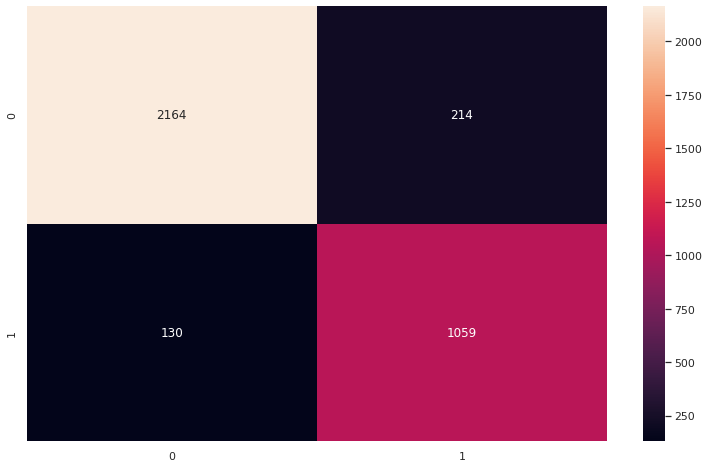

In [58]:
sns.heatmap(confusion_matrix(y_test,predictions2),annot=True,fmt='')

### We see from above confusion matrix that our new model has validation accuracy of 90.35 %. It is good like we did before. But now We got F1-Score of 0.86 which is so much better than what we got before. Our text classifier model is quite good. It will be able to distinguish the positive sentiment class values from the negative sentiment class values since we also got high ROC-AUC score, where 0.5 < Our ROC-AUC Score < 1.